## 1.) Importing Libraries

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

2025-01-30 10:13:32.230370: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 10:13:32.234656: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 10:13:32.248550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738212212.279462 1320083 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738212212.287111 1320083 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 10:13:32.317759: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### 2.) Preprocessing

### 2.1 Load Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/agilecpu154/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [3]:
train_dir = r'/home/agilecpu154/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'

folds = os.listdir(train_dir)
folds

['glioma', 'pituitary', 'notumor', 'meningioma']

In [4]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [5]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df(r'/home/agilecpu154/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training')
tr_df

Class Path       Class
0     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
1     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
2     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
3     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
4     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
...                                                 ...         ...
5707  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
5708  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
5709  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
5710  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
5711  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma

[5712 rows x 2 columns]

In [7]:
ts_df = test_df(r'/home/agilecpu154/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing')
ts_df

Class Path       Class
0     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
1     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
2     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
3     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
4     /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
...                                                 ...         ...
1306  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
1307  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
1308  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
1309  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
1310  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma

[1311 rows x 2 columns]

### 2.2 Split data into train,test and valid

In [8]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=42, stratify=ts_df['Class'])

In [9]:
valid_df

Class Path       Class
837   /home/agilecpu154/.cache/kagglehub/datasets/ma...     notumor
1034  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
770   /home/agilecpu154/.cache/kagglehub/datasets/ma...     notumor
158   /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
1296  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
...                                                 ...         ...
1182  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma
127   /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
109   /home/agilecpu154/.cache/kagglehub/datasets/ma...      glioma
758   /home/agilecpu154/.cache/kagglehub/datasets/ma...     notumor
1175  /home/agilecpu154/.cache/kagglehub/datasets/ma...  meningioma

[655 rows x 2 columns]

### 2.3 Data PreProcessing

In [10]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 3. Building Deep Learning Model

In [11]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

base_model.trainable = False

inputs = Input(shape = img_shape)

x = base_model(inputs)

x = Flatten()(x)

x = Dropout(rate= 0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= 0.25)(x)
x = Dense(4, activation= 'softmax')(x)
    
model = Model(inputs, x)

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()]) 

2025-01-30 10:13:53.840764: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
import pydot
tf.keras.utils.plot_model(model, show_shapes=True, to_file='/kaggle/working/model.png', dpi=70)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## 4. Training

In [14]:
hist = model.fit(tr_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5


2025-01-30 10:14:32.987462: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.
2025-01-30 10:14:33.410358: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.
2025-01-30 10:14:33.644193: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 354041856 exceeds 10% of free system memory.
2025-01-30 10:14:34.254200: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 354041856 exceeds 10% of free system memory.
2025-01-30 10:14:34.484259: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 354041856 exceeds 10% of free system memory.


179/179 ━━━━━━━━━━━━━━━━━━━━ 1849s 10s/step - accuracy: 0.6173 - loss: 1.1318 - precision: 0.6600 - recall: 0.5509 - val_accuracy: 0.8244 - val_loss: 0.4391 - val_precision: 0.8634 - val_recall: 0.7817
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2654s 15s/step - accuracy: 0.8219 - loss: 0.4929 - precision: 0.8444 - recall: 0.7867 - val_accuracy: 0.8351 - val_loss: 0.4164 - val_precision: 0.8611 - val_recall: 0.8046
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2559s 14s/step - accuracy: 0.8391 - loss: 0.4235 - precision: 0.8611 - recall: 0.8159 - val_accuracy: 0.8443 - val_loss: 0.3742 - val_precision: 0.8701 - val_recall: 0.8183
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 2078s 12s/step - accuracy: 0.8633 - loss: 0.3738 - precision: 0.8802 - recall: 0.8432 - val_accuracy: 0.8962 - val_loss: 0.3218 - val_precision: 0.9091 - val_recall: 0.8702
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 1960s 11s/step - accuracy: 0.8733 - loss: 0.3367 - precision: 0.8865 - recall: 0.8581 - val_accuracy: 0.8916 - val_loss: 0.

In [18]:
model.save("results/brain_tumor_model.h5")

In [15]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [16]:
tr_gen.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

## 5. Fine Tuning

In [17]:
len(base_model.layers)

133

In [21]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

history_fine = model.fit(tr_gen,
                 epochs=2,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 6156s 34s/step - accuracy: 0.8788 - loss: 0.3437 - precision_2: 0.9044 - recall_2: 0.8567 - val_accuracy: 0.9435 - val_loss: 0.1301 - val_precision_2: 0.9450 - val_recall_2: 0.9435
Epoch 2/2
179/179 ━━━━━━━━━━━━━━━━━━━━ 5506s 31s/step - accuracy: 0.9814 - loss: 0.0527 - precision_2: 0.9822 - recall_2: 0.9808 - val_accuracy: 0.9802 - val_loss: 0.0601 - val_precision_2: 0.9802 - val_recall_2: 0.9802


In [31]:
model.save(r"/home/agilecpu154/Documents/Task-7 Brain Tumor CNN/final/brain_tumor_fine_tune.h5")

In [33]:
print(history_fine.history.keys())

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])


## 6. Visualisation

### 6.1 Visualize model performance

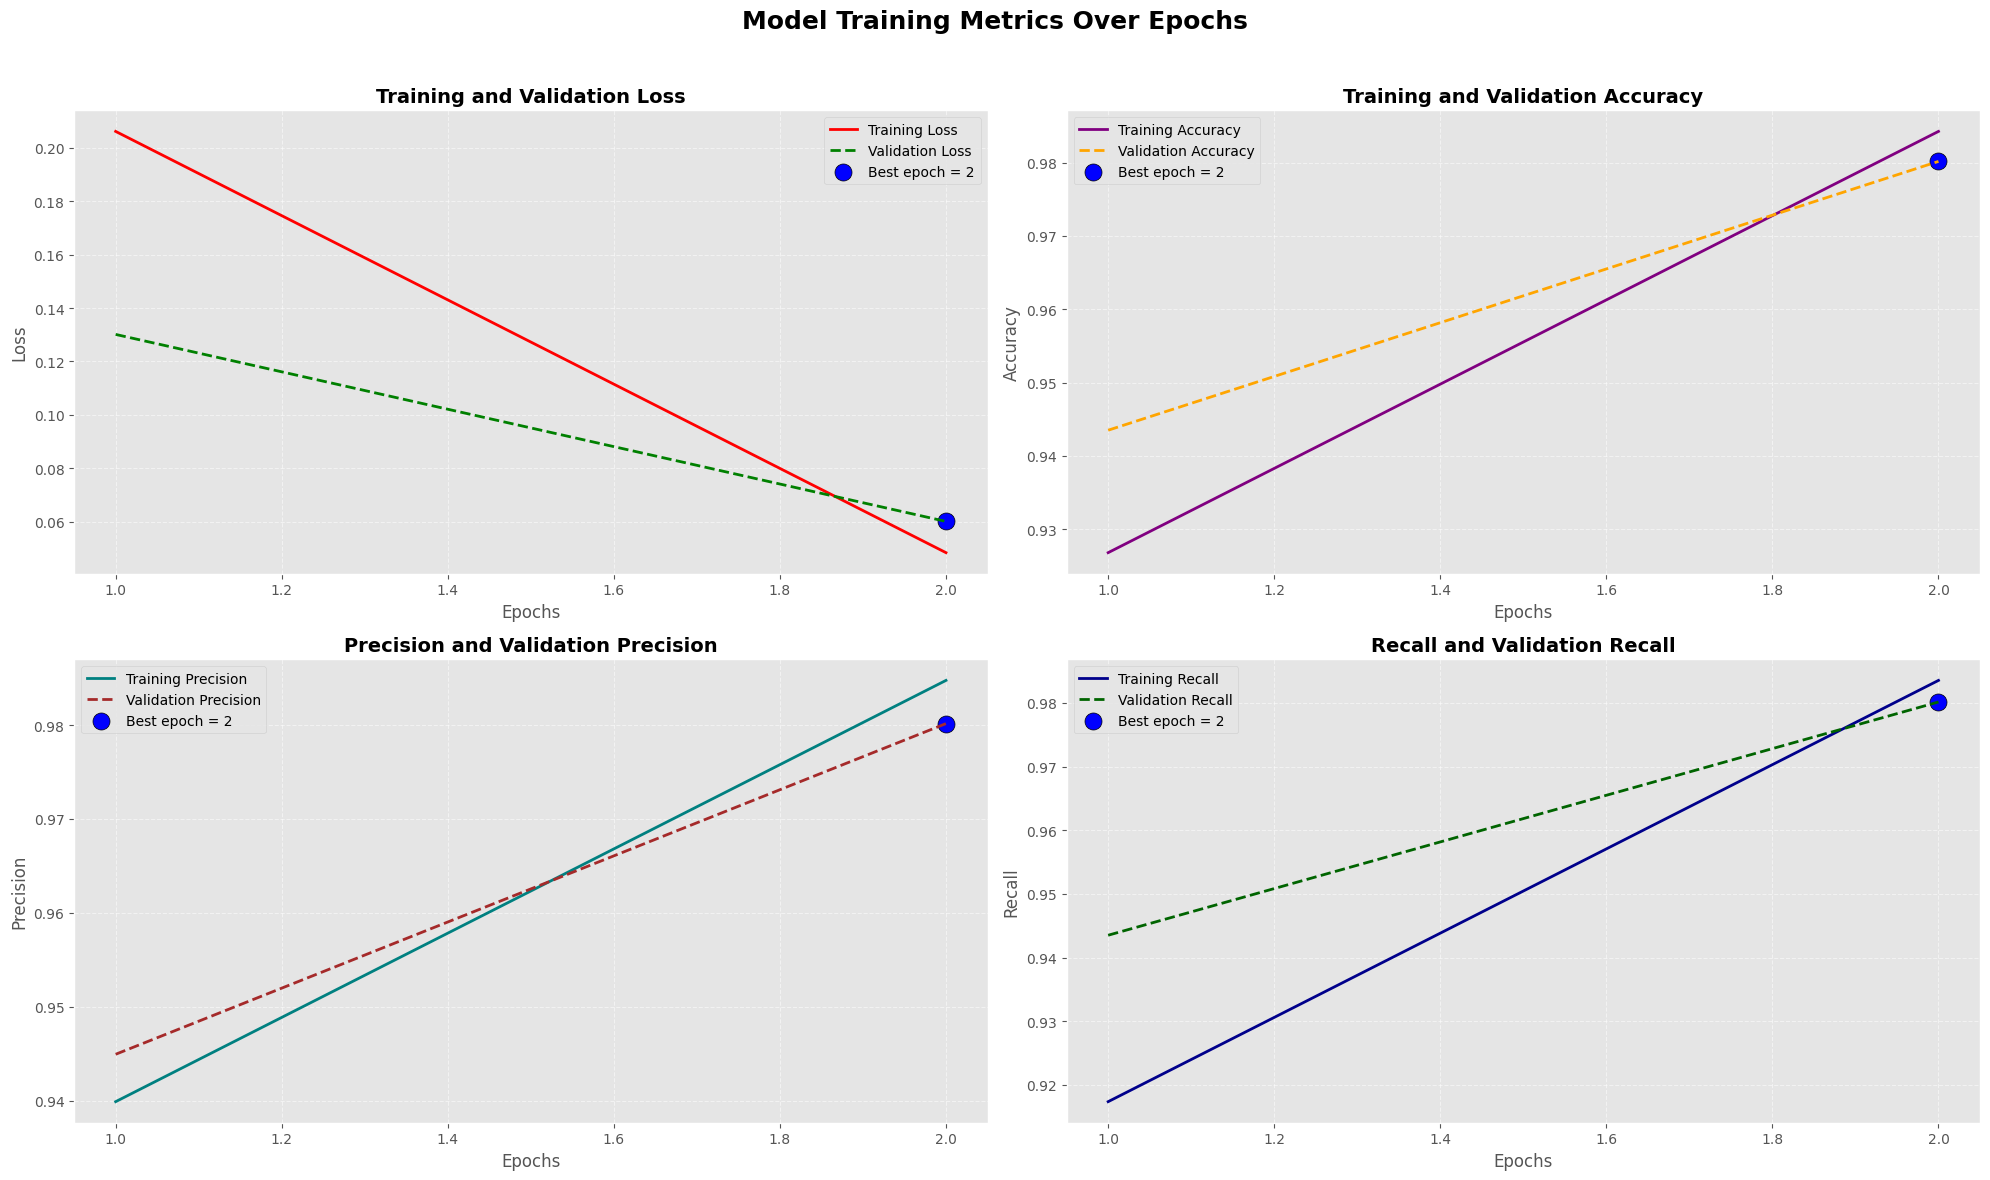

In [34]:
tr_acc = history_fine.history['accuracy']
tr_loss = history_fine.history['loss']
tr_per = history_fine.history['precision_2']
tr_recall = history_fine.history['recall_2']
val_acc = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']
val_per = history_fine.history['val_precision_2']
val_recall = history_fine.history['val_recall_2']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Define a modern style
plt.style.use('ggplot')
plt.figure(figsize=(20, 12))

# Plot Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, color='red', label='Training Loss', linewidth=2)
plt.plot(Epochs, val_loss, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label, edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, color='purple', label='Training Accuracy', linewidth=2)
plt.plot(Epochs, val_acc, color='orange', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label, edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Plot Precision and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, color='teal', label='Training Precision', linewidth=2)
plt.plot(Epochs, val_per, color='brown', label='Validation Precision', linestyle='--', linewidth=2)
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label, edgecolors='black')
plt.title('Precision and Validation Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Plot Recall and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, color='darkblue', label='Training Recall', linewidth=2)
plt.plot(Epochs, val_recall, color='darkgreen', label='Validation Recall', linestyle='--', linewidth=2)
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label, edgecolors='black')
plt.title('Recall and Validation Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Add a title for the entire figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 7. Testing and Evaluation 

### 7.1 Evaluate

In [35]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

  3/179 ━━━━━━━━━━━━━━━━━━━━ 31:58 11s/step - accuracy: 1.0000 - loss: 0.0032 - precision_2: 1.0000 - recall_2: 1.0000    

KeyboardInterrupt: 

In [36]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step


In [37]:
class_dict = tr_gen.class_indices

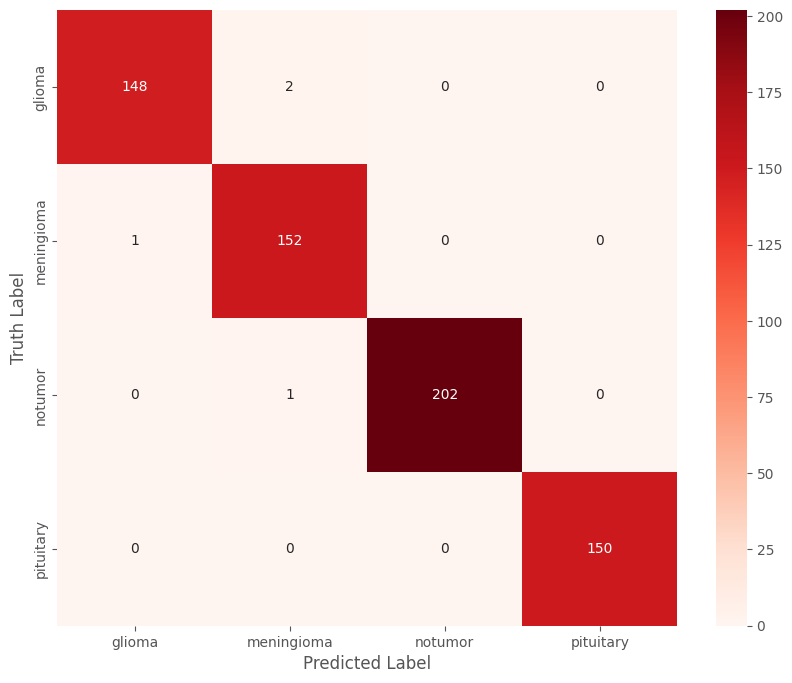

In [38]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [39]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.98      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



### 7.2 Testing

In [40]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


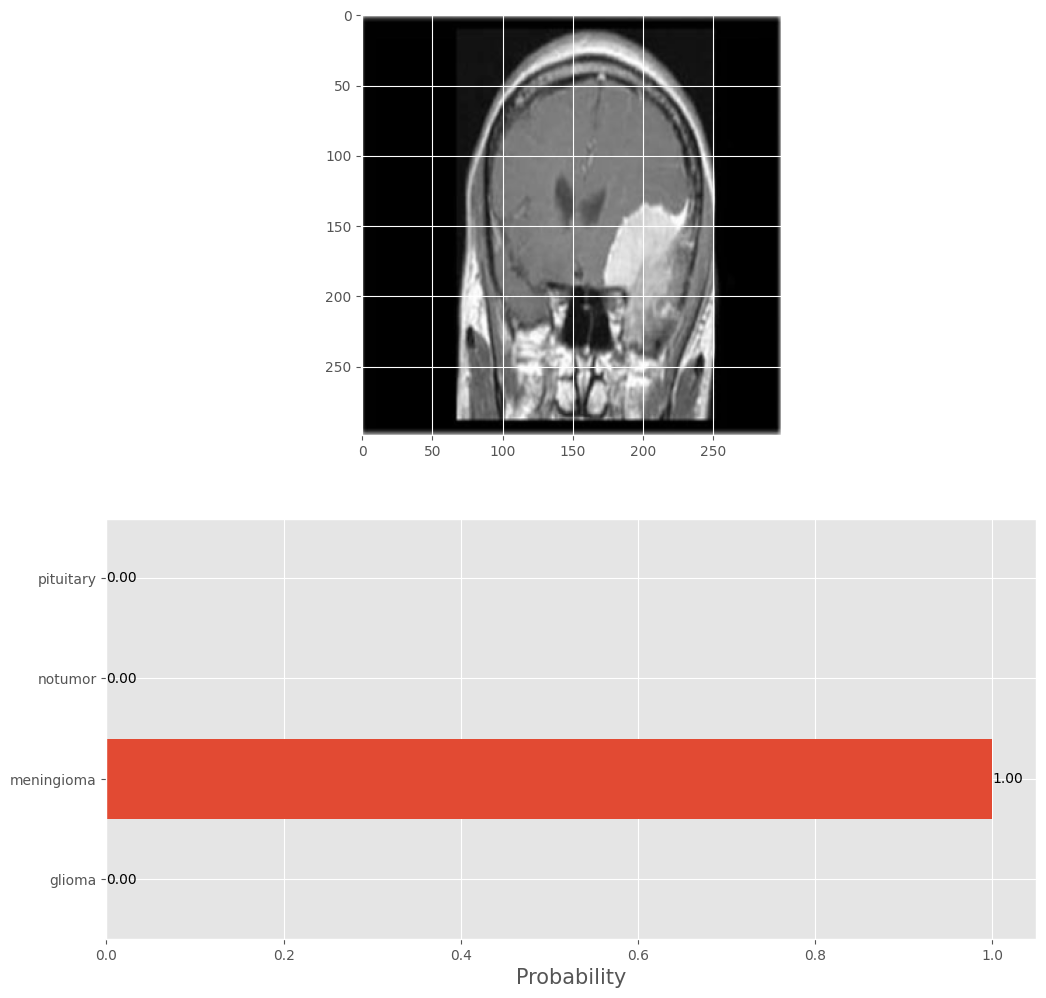

In [42]:
predict(r'/home/agilecpu154/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/meningioma/Te-meTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


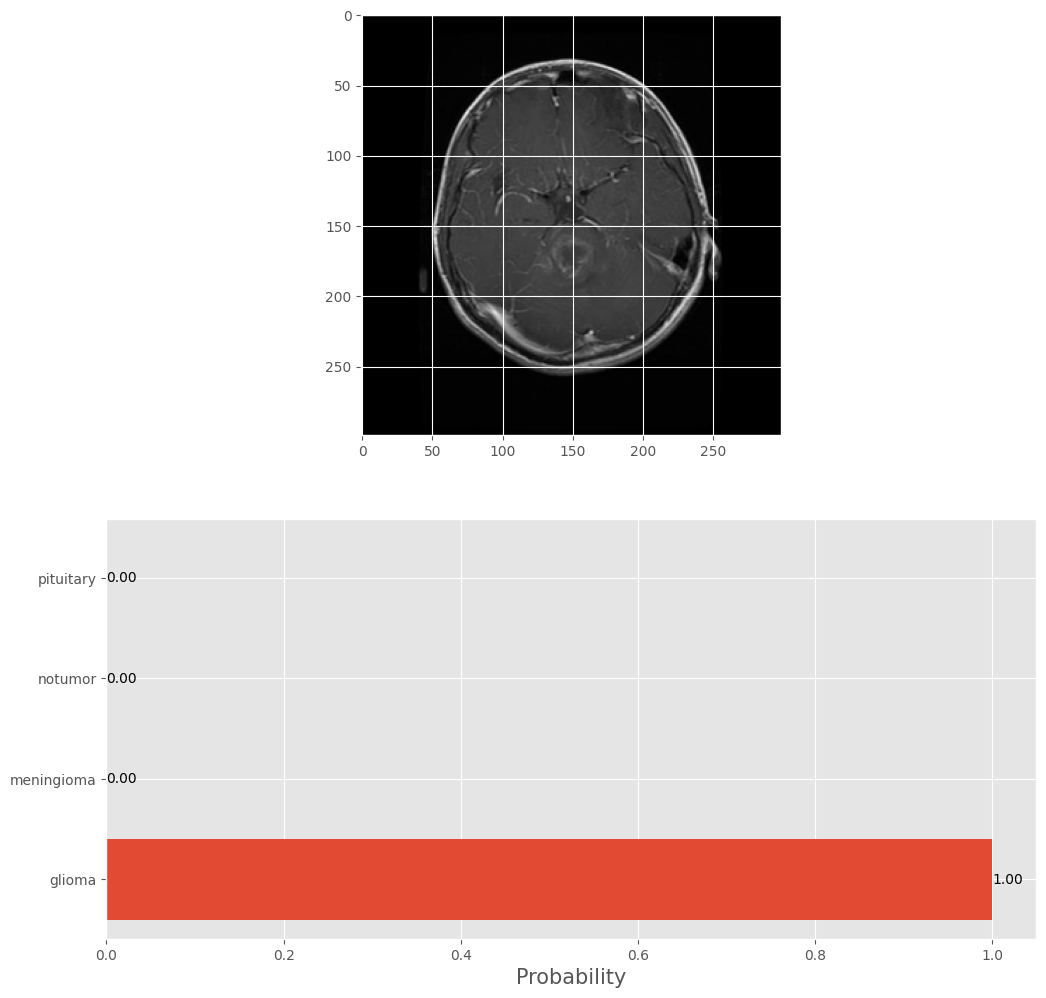

In [43]:
predict(r'/home/agilecpu154/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-glTr_0007.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


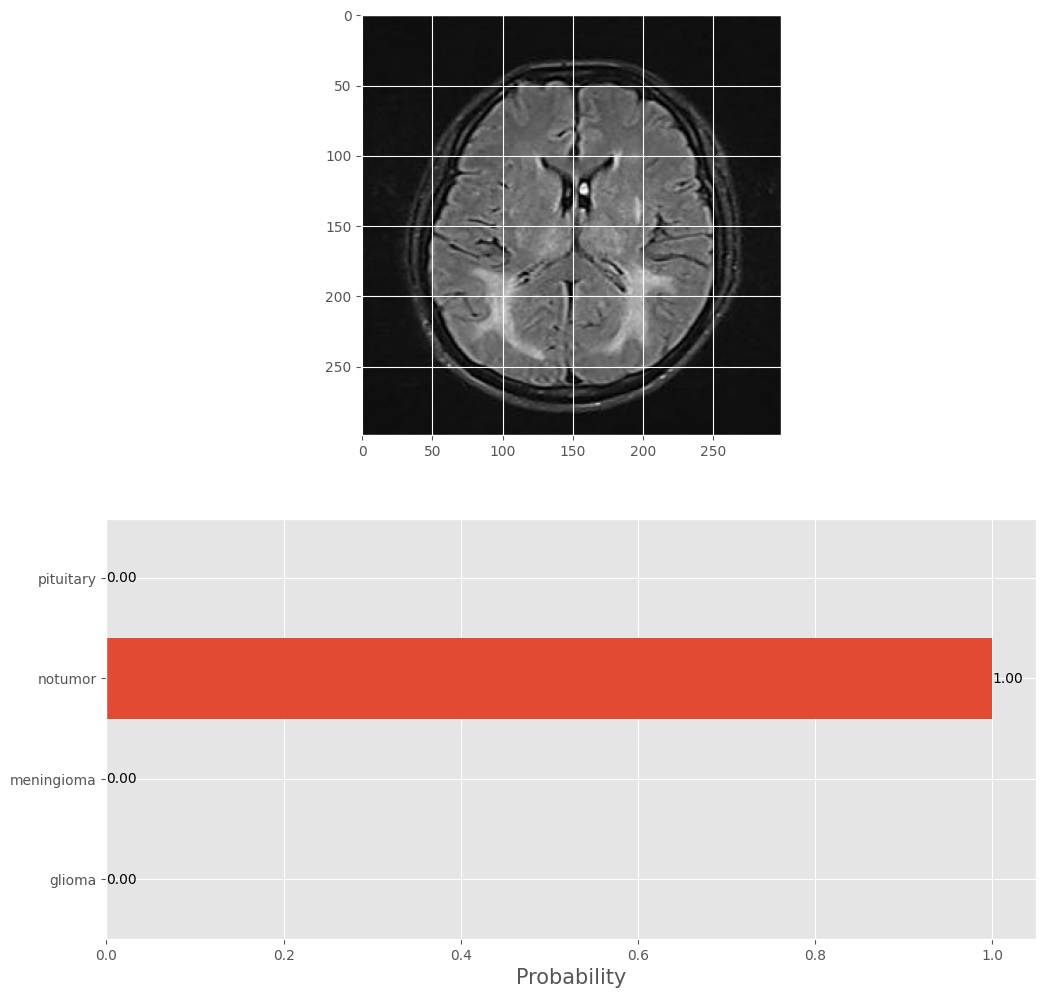

In [44]:
predict(r'/home/agilecpu154/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-noTr_0001.jpg')

## 8. GRadio Interface for classifying brain tumors

In [47]:
import gradio as gr
import numpy as np

# Load the model

model.load_weights("final/brain_tumor_fine_tune.h5")


class_names = [
    'glioma',
    'meningioma',
    'notumor',
    'pituitary',
]

def classify_tumor(input_image):
    
    img = Image.fromarray(input_image)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    prediction = model.predict(img)
    
    confidences = {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}
    
    return {class_name: conf for class_name, conf in sorted(confidences.items(), key=lambda x: x[1], reverse=True)}

iface = gr.Interface(
    fn=classify_tumor,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=5),
    title="Brain Tumor Classification",
    description="Upload an image of a Brain to classify its tumor.",
    theme=gr.themes.Soft()
)

# Launch the interface
iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://f76ce94557f9059997.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
